<a href="https://colab.research.google.com/github/cristinarainich/MLTSA22_KRainich/blob/main/HW3/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import pylab as pl
import glob
%pylab inline

import statsmodels.api as sm
from pandas.plotting import scatter_matrix
import json
import os

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
pl.style.use("https://raw.githubusercontent.com/fedhere/MLTSA22_FBianco/master/fbb.mplstyle")

In [3]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [4]:
cd /content/gdrive/MyDrive//MLTSA22/HW2/Data

/content/gdrive/MyDrive/MLTSA22/HW2/Data


In [5]:
files = glob.glob("Data/Stocks/*.txt")
allfiles = np.sort(np.array(files))

In [6]:
allfiles[:10]

array(['Data/Stocks/a.us.txt', 'Data/Stocks/aa.us.txt',
       'Data/Stocks/aaap.us.txt', 'Data/Stocks/aaba.us.txt',
       'Data/Stocks/aac.us.txt', 'Data/Stocks/aal.us.txt',
       'Data/Stocks/aamc.us.txt', 'Data/Stocks/aame.us.txt',
       'Data/Stocks/aan.us.txt', 'Data/Stocks/aaoi.us.txt'], dtype='<U28')

In [7]:
tss = pd.read_csv(allfiles[0])
tss = tss[['Date', 'Close']]
tss = tss.rename(columns = {'Close': 'a'})
for i in allfiles[1:10]:
  df = pd.read_csv(i)
  tss = tss.merge(df[['Date', 'Close']], on = 'Date')
  tss = tss.rename(columns = {'Close': str(i[12:-7])})

In [8]:
tss.set_index("Date", inplace=True)

In [9]:
threshold = 0.05
print ("Stationarity results from the AD Fuller test at a p-value of 0.05")
for i in tss.columns:
    pvalue = sm.tsa.stattools.adfuller(tss[i])[1] #the function returns MacKinnon’s approximate p-value
    if pvalue <= threshold:
      print(i + ' is stationary: True')
    else:
      print(i + ' is stationary: False')

Stationarity results from the AD Fuller test at a p-value of 0.05
a is stationary: False
aa is stationary: False
aaap is stationary: False
aaba is stationary: False
aac is stationary: False
aal is stationary: False
aamc is stationary: False
aame is stationary: True
aan is stationary: False
aaoi is stationary: False


Question: *why did I set the threshold to 0.05? what does 0.05 mean?*
Augmented Dickey–Fuller test (ADF)  common statistical test used to test whether a given Time series is stationary or not. The null hypothesis is that time series is non-stationary. The alternative hypothesis is hat time series is stationary.  
The significance level states that there is a 95% probability that we observe the particular result because alternative hypothesis is true. In other words, that there is a 5% chance that we observed this result given that the null hypothesis is actually true. The significance level threshold is usually set to 0.05 in psychology field, however, it could very depending on the field and the stude design. For instance, in clinical field, the common threshodl used is 0.01. 

# Autocorrelation and partial autocorrelation

findfont: Font family ['["sans-serif"]'] not found. Falling back to DejaVu Sans.
findfont: Font family ['["sans-serif"]'] not found. Falling back to DejaVu Sans.


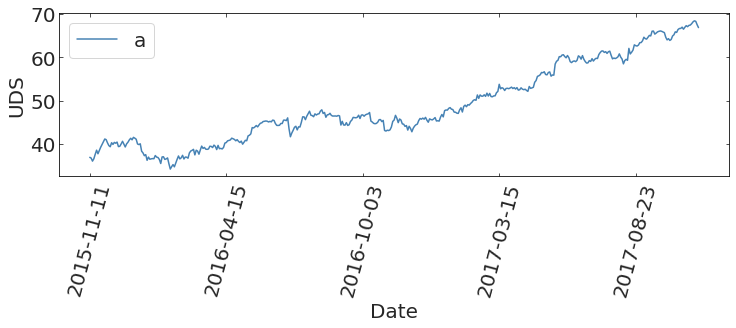

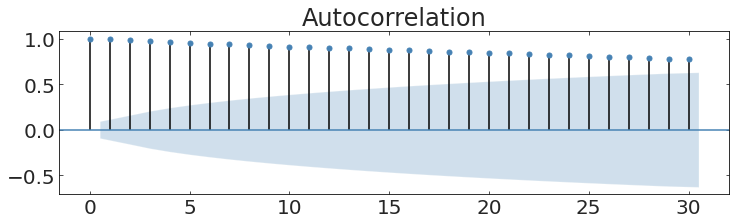

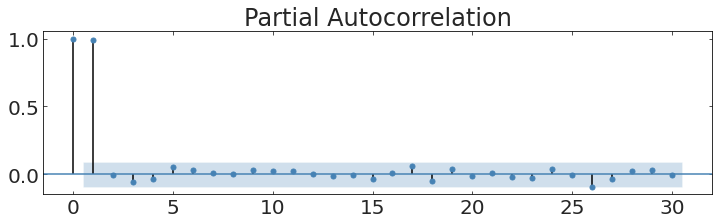

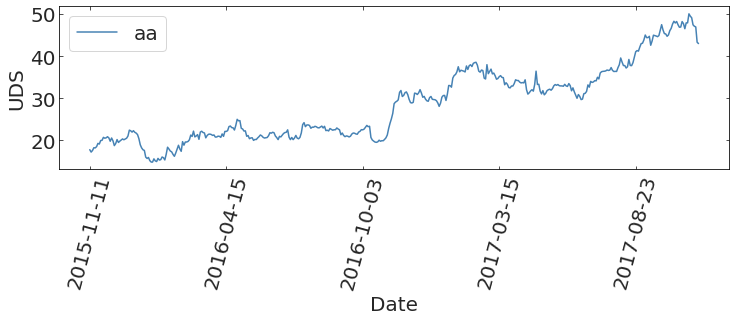

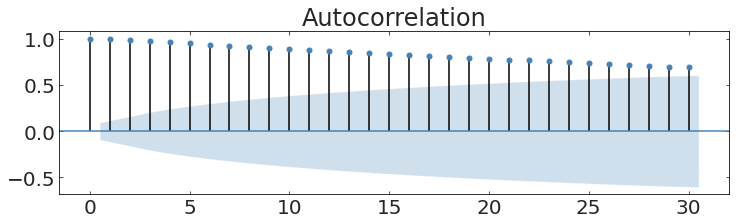

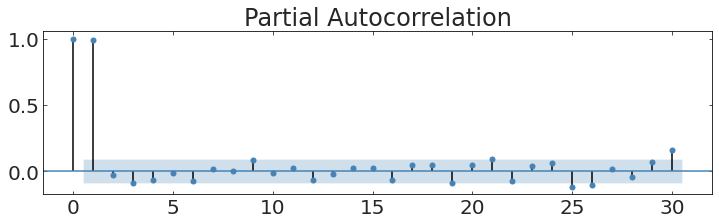

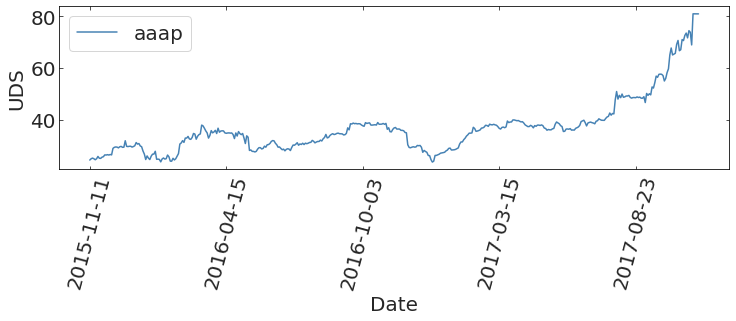

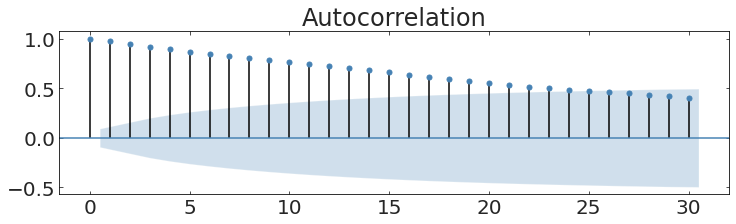

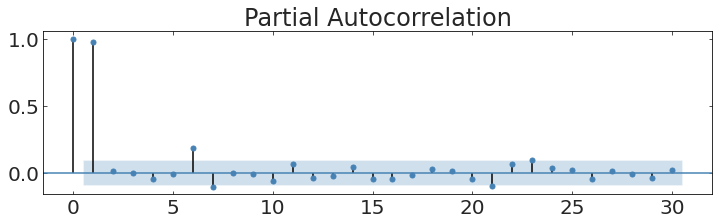

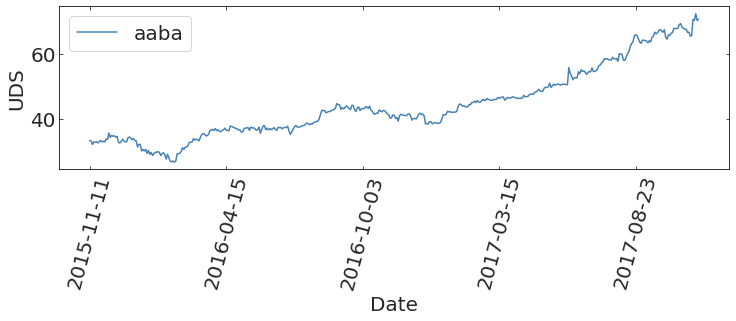

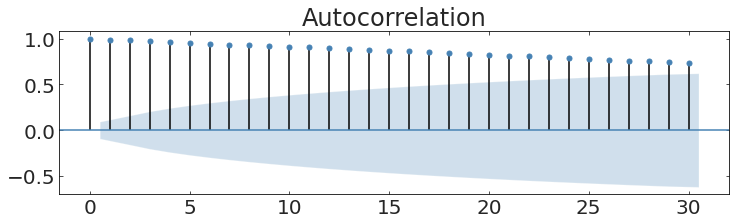

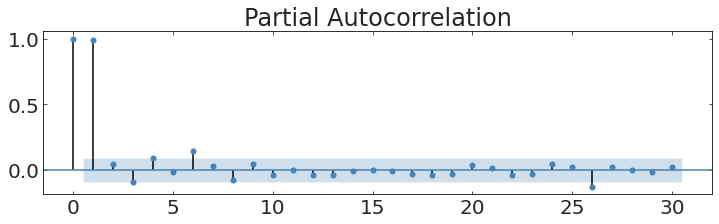

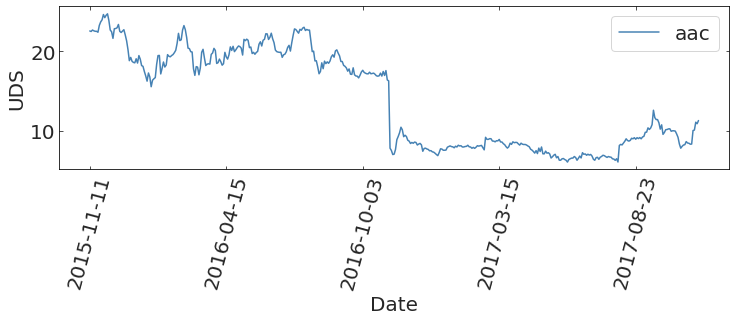

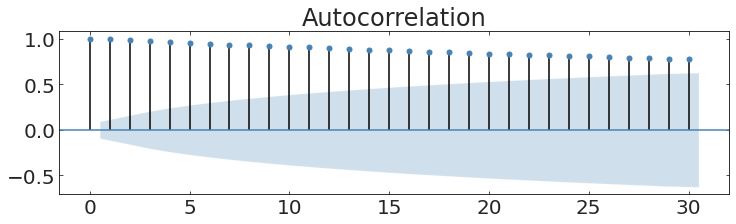

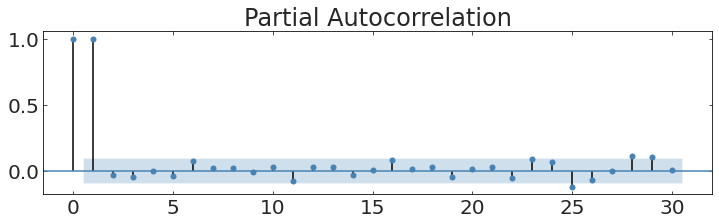

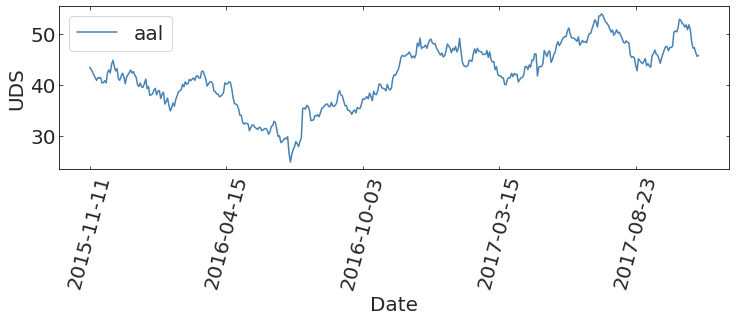

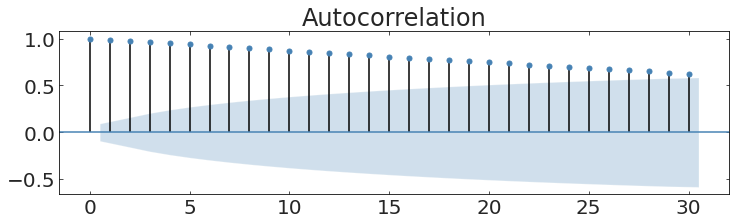

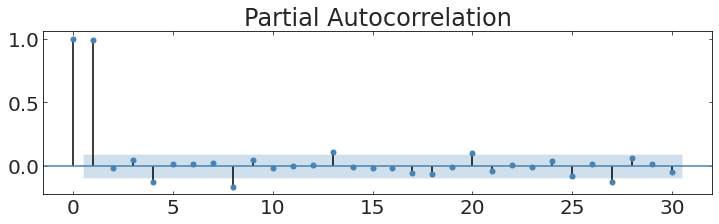

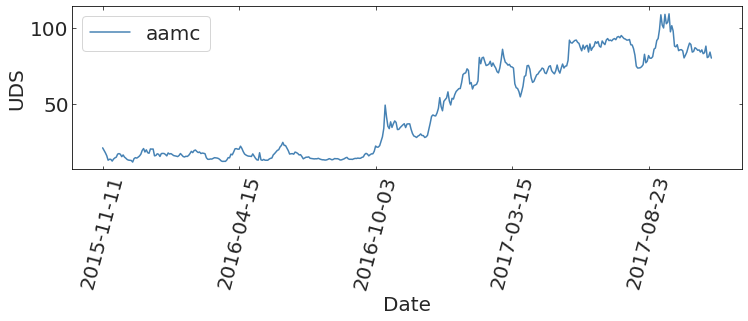

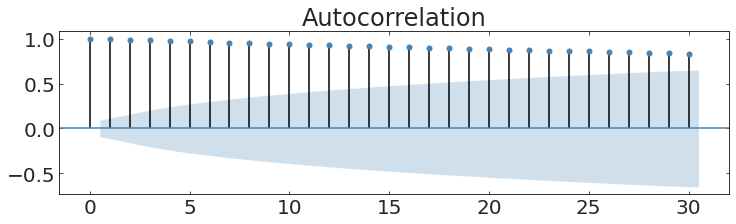

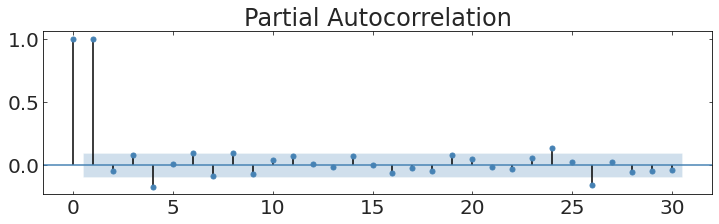

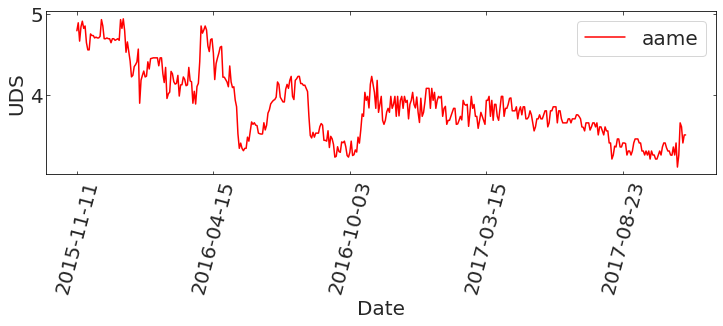

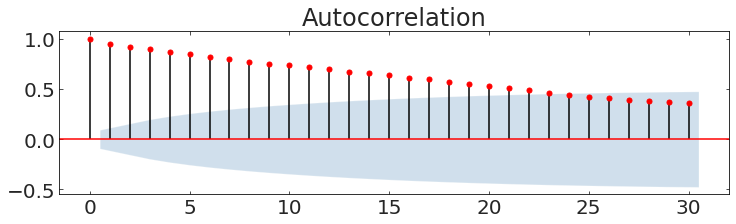

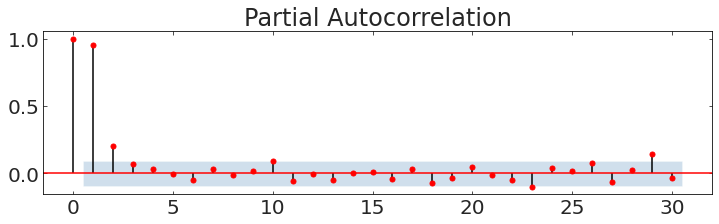

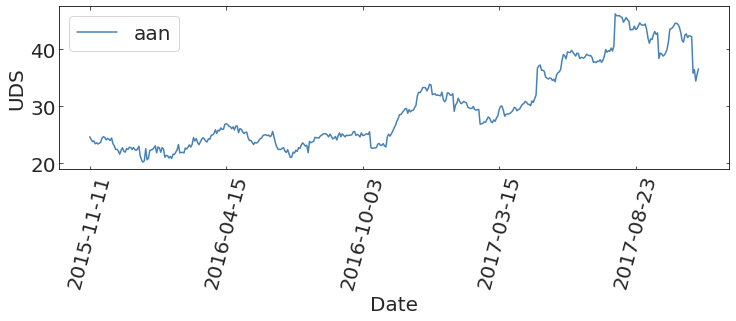

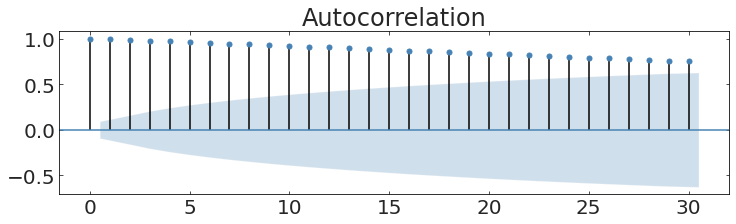

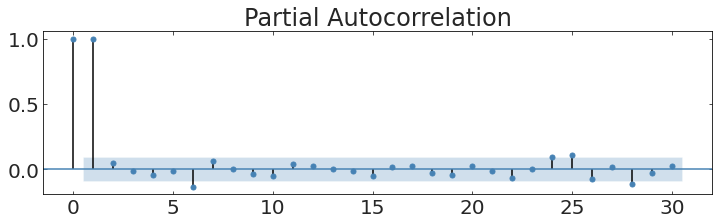

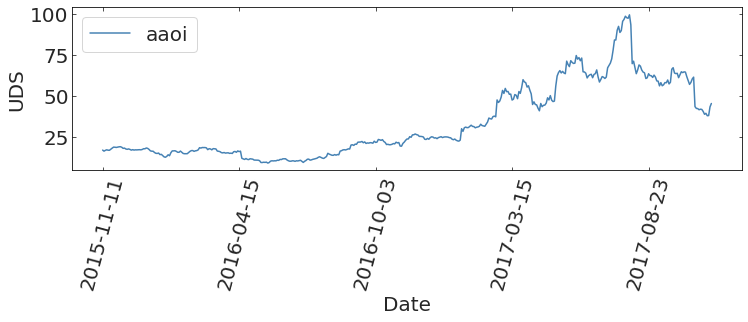

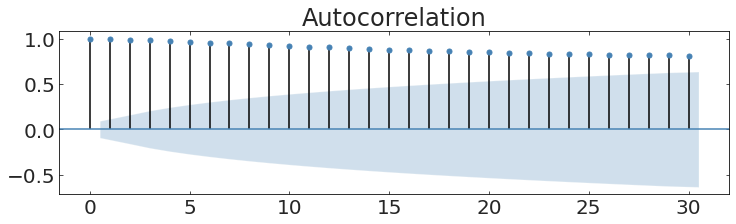

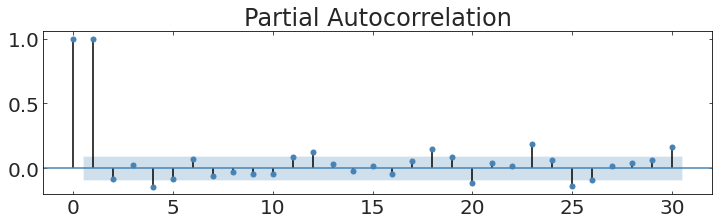

In [10]:
for i in tss.columns:
  pvalue = sm.tsa.stattools.adfuller(tss[i])[1]
  if pvalue <= threshold:
    tss.plot(y = i, rot=75, figsize=(12,3), color = 'r');
    pl.ylabel("UDS", fontsize=20)
    ax = pl.figure(figsize=(12,3)).add_subplot(111)
    sm.graphics.tsa.plot_acf(tss[i], lags=30, ax=ax, color = 'r')
    ax = pl.figure(figsize=(12,3)).add_subplot(111)
    fig = sm.graphics.tsa.plot_pacf(tss[i], lags=30, ax=ax, color = 'r');
  else:
    tss.plot(y = i, rot=75, figsize=(12,3));
    pl.ylabel("UDS", fontsize=20)
    ax = pl.figure(figsize=(12,3)).add_subplot(111)
    sm.graphics.tsa.plot_acf(tss[i], lags=30, ax=ax)
    ax = pl.figure(figsize=(12,3)).add_subplot(111)
    fig = sm.graphics.tsa.plot_pacf(tss[i], lags=30, ax=ax);

Fig. 1. There are three subplots for each of the 10 US-based stocks trading. The first of subplots depicts the change in daily closing price for a stock over time. The second of subplots is an autocorrelation function for a stock picturing a correlation of a time series with a delayed copy of itself as a function of delay (i.e. the similarity between observations as a function of the time lag between them). The thirs of subplots is partial autocorrelation function for a stock, which is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed.

Question: *pick one of the time series (of your choice) and tell me which lags are expected to be significant in the model based on the ACF and PACF plots you made*
For instance, for **aaoi** stock (last series of subplots), based on ACF, all the lags are expected to be significant. Based on the PACF, 9 of the lags are supposed to be significant, namely, 0, 1, 4, 12, 18, 20, 23, 25, and 30. Lags 2, 5, 11, 19, and 26 are under question and on the verge of significance. 

# Model and forecast

Training and testing split for stationary **aame** time series

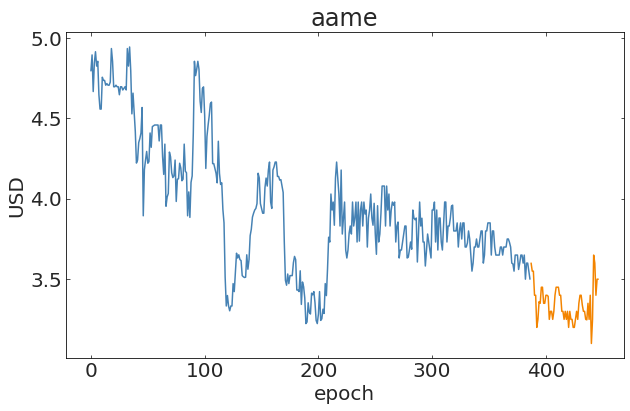

In [11]:
pl.plot(np.arange(tss.shape[0] - 60), tss.loc[:,"aame"][:-60])
pl.plot(np.arange(tss.shape[0] - 60, tss.shape[0]), tss.loc[:,"aame"][-60:]);
pl.title("aame")
pl.xlabel("epoch")
pl.ylabel("USD");

Fig. 2. Depicting the split of data in aame time series into training (in blue) and testing (in orange) sets

**ARMA model for stationary time series aame**

Trying out the ARMA model for aame with parameters p and q equal to 1

In [12]:
mod = sm.tsa.ARMA(tss.loc[:,'aame'][:-60], (1,1)).fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                   aame   No. Observations:                  387
Model:                     ARMA(1, 1)   Log Likelihood                 249.303
Method:                       css-mle   S.D. of innovations              0.127
Date:                Wed, 02 Mar 2022   AIC                           -490.605
Time:                        00:35:03   BIC                           -474.772
Sample:                             0   HQIC                          -484.327
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.9933      0.184     21.678      0.000       3.632       4.354
ar.L1.aame     0.9765      0.012     82.087      0.000       0.953       1.000
ma.L1.aame    -0.2624      0.052     -5.073      0.000      -0.364      -0.161
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0241           +0.0000j            1.0241            0.0000
MA.1            3.8105           +0.0000j            3.8105            0.0000
-----------------------------------------------------------------------------
"""

Finding the best parameters for the model

In [39]:
aics = np.zeros((5,5))
for p in range(1,6):
  for q in range(1,6):
      try:
        aics[p-1][q-1] = sm.tsa.ARMA(tss.loc[:,'aame'][:-60], (p, q)).fit().aic              
      except:
        aics[p-1][q-1] = np.nan
add1 = sm.tsa.ARMA(tss.loc[:,'aame'][:-60], (0, 1)).fit().aic
add2 = sm.tsa.ARMA(tss.loc[:,'aame'][:-60], (1, 0)).fit().aic
if np.nanmin(aics) < add1:
  if np.nanmin(aics) < add2:
    p, q = np.where(aics == np.nanmin(aics))
    p += 1
    q += 1          
    print("best parameters: p: {:d} q: {:d}".format(p[0],q[0]))
  else: 
    print("best parameters: p: 1 q: 0")
else:
  if add1 > add2:
    print("best parameters: p: 1 q: 0")
  else:
    print("best parameters: p: 0 q: 1")

best parameters: p: 3 q: 3


Prediction for the best chosen parameters

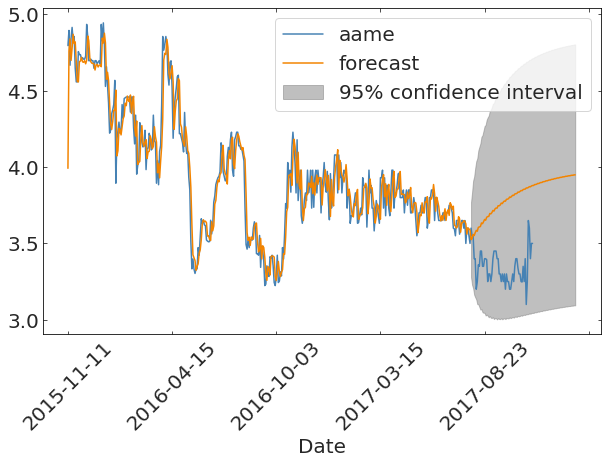

In [40]:
N = tss[['aame']].shape[0]
ax = tss[['aame']].plot()
mod = sm.tsa.ARMA(tss.loc[:,'aame'][:-60], (3,3)).fit()
mod.plot_predict(end = N + 40, plot_insample=False, ax=ax);
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

Fig. 3. The change in stock price over time based on the actual data (in blue) and the prediction of ARMA model (in orange)

Question: *Did you make money??*
Based on the graph, our prediction was not really close to the actual data. I would say that we expected the price to be higher than it's actuall was and would be, so we most probably lost our money.

Question: *what are the coefficients of the best fit model? what do they mean?*
The best coefficients for our model were p = 3 and q = 3 based on the optimization of AIC (the smallest value for tested parameters). The coefficient p stands for the lag order, the number of lag observatios in the AM model, whereas the coefficient q - for the order of MA, i.e. the size of MA window. 
Actually, based on PACF for aame stock depicted above, there are 3 lags that are expected to be significant, which corresponds to our chosen p coefficient. 

**ARIMA model for non-stationary time series**

Let's first find the least correlated non-stationary time series

In [15]:
corr_table = tss.corr()
min_number = corr_table.loc['a', 'a']
for i in corr_table:
  for j in corr_table:
    if i != 'aame' and j != 'aame':
      if abs(corr_table.loc[i, j]) < abs(min_number):
        min_number = corr_table.loc[i, j]
        coord = (i, j)
print(min_number, coord)


-0.4230206537836328 ('aaap', 'aac')


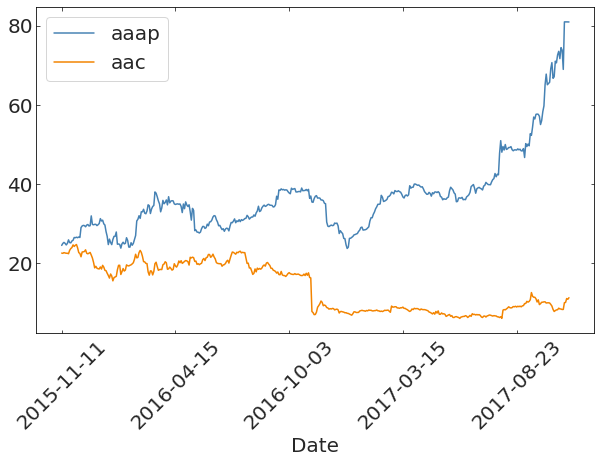

In [16]:
ax = tss['aaap'].plot()
tss['aac'].plot(ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);
pl.legend()

Fig. 4. The change in daily closing price for aaap (in blue) and aac (in orange) stocks over time

**ARIMA model for aaap stock**

In [41]:
aics1 = np.zeros((5,5))
for p in range(1,6):
    for q in range(1,6):
        try:
          mod = sm.tsa.ARIMA(tss.loc[:,'aaap'][:-60], (p,1,q)).fit()  
          aics1[p-1][q-1] = mod.aic
        except:
          aics1[p-1][q-1] = np.nan
add1 = sm.tsa.ARIMA(tss.loc[:,'aaap'][:-60], (0,1,1)).fit().aic
add2 = sm.tsa.ARIMA(tss.loc[:,'aaap'][:-60], (1,1,0)).fit().aic
if np.nanmin(aics1) < add1:
  if np.nanmin(aics1) < add2:
    p, q = np.where(aics1 == np.nanmin(aics1))
    p += 1
    q += 1          
    print("best parameters: p: {:d} q: {:d}".format(p[0],q[0]))
  else: 
    print("best parameters: p: 1 q: 0")
else:
  if add1 > add2:
    print("best parameters: p: 1 q: 0")
  else:
    print("best parameters: p: 0 q: 1")

best parameters: p: 1 q: 0


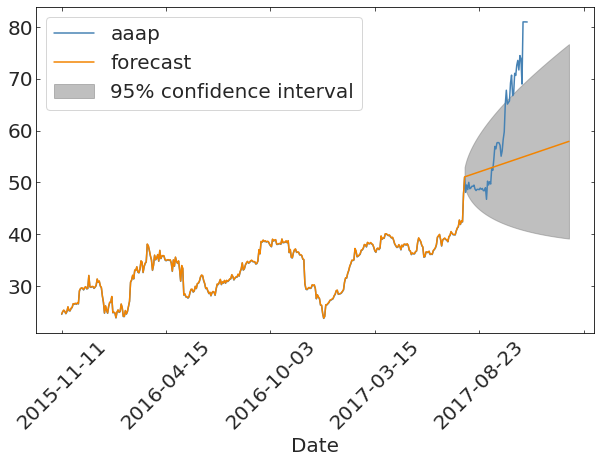

In [42]:
N1 = tss[['aaap']].shape[0]
ax = tss[['aaap']].plot()
mod = sm.tsa.ARIMA(tss.loc[:,'aaap'][:-60], (1,1,0)).fit()
mod.plot_predict(end = N1 + 40, plot_insample=False, ax=ax);
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

Fig. 5. The change in stock price over time based on the actual data (in blue) and the prediction of ARIMA model (in orange)

Question: *Did you get rich?*
Our predictions were that price would be much lower that it actually was. So we didn't lose our money, but if our prediction worked better, we could've earned much more. 

**ARIMA model for aac stock**

In [43]:
aics2 = np.zeros((5,5))
for p in range(1,6):
    for q in range(1,6):
            try:
                mod = sm.tsa.ARIMA(tss.loc[:,'aac'][:-60], (p,1,q)).fit()  
                aics2[p-1][q-1] = mod.aic
            except:
                aics2[p-1][q-1] = np.nan
add1 = sm.tsa.ARIMA(tss.loc[:,'aac'][:-60], (0,1,1)).fit().aic
add2 = sm.tsa.ARIMA(tss.loc[:,'aac'][:-60], (1,1,0)).fit().aic
if np.nanmin(aics2) < add1:
  if np.nanmin(aics2) < add2:
    p, q = np.where(aics2 == np.nanmin(aics2))
    p += 1
    q += 1          
    print("best parameters: p: {:d} q: {:d}".format(p[0],q[0]))
  else: 
    print("best parameters: p: 1 q: 0")
else:
  if add1 > add2:
    print("best parameters: p: 1 q: 0")
  else:
    print("best parameters: p: 0 q: 1")

best parameters: p: 1 q: 1


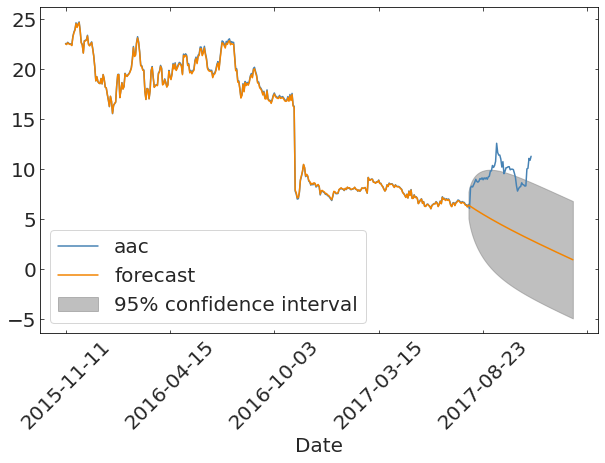

In [44]:
N2 = tss[['aac']].shape[0]
ax = tss[['aac']].plot()
mod = sm.tsa.ARIMA(tss.loc[:,'aac'][:-60], (1,1,1)).fit()
mod.plot_predict(end = N2 + 40, plot_insample=False, ax=ax);
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

Fig. 6. The change in stock price over time based on the actual data (in blue) and the prediction of ARIMA model (in orange)

Question: *Did you get rich?* 
Same here, we expected the price to drop, but it was gradually rising, so we could've earned more money.

**Changing the order of integration for one of the stocks**

Finding the best parameters p and q while minimazing AIC for the order of integration equal to 2

In [45]:
aics3 = np.zeros((5,5))
for p in range(1,6):
    for q in range(1,6):
            try:
                mod = sm.tsa.ARIMA(tss.loc[:,'aac'][:-60], (p,2,q)).fit()  
                aics3[p-1][q-1] = mod.aic
            except:
                aics3[p-1][q-1] = np.nan
add1 = sm.tsa.ARIMA(tss.loc[:,'aac'][:-60], (0,2,1)).fit().aic
add2 = sm.tsa.ARIMA(tss.loc[:,'aac'][:-60], (1,2,0)).fit().aic
if np.nanmin(aics3) < add1:
  if np.nanmin(aics3) < add2:
    p, q = np.where(aics3 == np.nanmin(aics3))
    p += 1
    q += 1          
    print("best parameters: p: {:d} q: {:d}".format(p[0],q[0]))
  else: 
    print("best parameters: p: 1 q: 0")
else:
  if add1 > add2:
    print("best parameters: p: 1 q: 0")
  else:
    print("best parameters: p: 0 q: 1")

best parameters: p: 2 q: 3


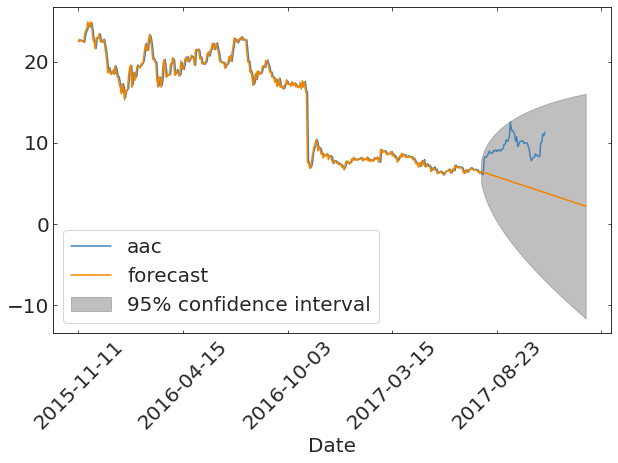

In [46]:
new_N = tss[['aac']].shape[0]
ax = tss[['aac']].plot()
model = sm.tsa.ARIMA(tss.loc[:,'aac'][:-60], (2,2,3)).fit()
model.plot_predict(end = new_N + 40, plot_insample = False, ax =ax);
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

Fig. 7. The change in stock price over time based on the actual data (in blue) and the prediction of ARIMA model (in orange) with other order of integration.

Question: *What do the coefficients tell you?* Our results based on the graphs didn't really change in terms of the prediction. However, for d = 2, which is the degree of differencing, i.e. the number of the raw observations are differenced, the most optimal p and q parameters changed to 2 and 3, respectively. Based on the PCAF graph for aac stock, there are two lags expected to be significant. Thus, with the increase of the degree of differencing the model was able to pick more optimap p parameter based on the data. 
Additionally, when we chose d = 2, confidentce intervals on the graph now includes the actual data, and our prediction isn't that steep anymore. 